# Hyperbolic Embeddings!

In this notebook, we use JAX to minimize the energy of a system in Euclidean and Hyperbolic space

In [20]:
import matplotlib.pyplot as plt
import jax.numpy as np
from jax import random, jit, vmap, grad

With JAX, we need to explicitly save the random state so we write some functions that help us generate initialization points

In [21]:
def random_point(key, scale=1e-3):
    weights = random.normal(key, (2,), dtype=np.float32)*scale
    return weights

def init_points(n, key):
    keys = random.split(key, n)
    return [random_point(k) for k in keys]

Here we define the euclidean distance and calculate energy of the system. We try to embed a tree structure by giving every node a point charge and connecting each pair of related nodes with a spring governed by hookes law. We calculate the elastic potential energy between two points as $e_h = d(x, y)^2$ and the electric potential energy as $\frac{1}{d(x, y)}$ We add the energies together and minimize it with RSGD.

In [26]:
e2 = lambda x, y: np.linalg.norm(x - y)
tensorMagnitude= lambda x:1

@jit
def energy(points):
    energy = 0
    for i in range(len(points)):
        for j in range(len(points)):
            if i == j:
                continue
            energy += 1/e2(points[i], points[j])
            if j == 4*i + 2 or j == 4*i + 1 or j == 4*i + 3 or j == 4*i + 4:
                energy += e2(points[i], points[j])**2
    return energy

dEnergy = jit(grad(energy))

def update(points, lr=1e-4):
    gradEnergy = dEnergy(points)
    return [p - 1/tensorMagnitude(p)*lr*g for p, g in zip(points, gradEnergy)]

In [27]:
points = init_points(21, key)
iterations = 100001
every = 5000
for i in range(iterations):
    if i % every == 0:
        print("%6d of %6d. Energy: %f" % (i, iterations, energy(points)))
    points = jit(update)(points, lr=1e-3)



     0 of 100000. Energy: 307285.437500
  5000 of 100000. Energy: 10751101.000000
 10000 of 100000. Energy: 347532.406250
 15000 of 100000. Energy: 11300.072266
 20000 of 100000. Energy: 484.815521
 25000 of 100000. Energy: 187.730270
 30000 of 100000. Energy: 183.181534
 35000 of 100000. Energy: 183.033600
 40000 of 100000. Energy: 183.025787
 45000 of 100000. Energy: 183.025558
 50000 of 100000. Energy: 183.025482
 55000 of 100000. Energy: 183.025589
 60000 of 100000. Energy: 183.025604
 65000 of 100000. Energy: 183.025604
 70000 of 100000. Energy: 183.025604
 75000 of 100000. Energy: 183.025604
 80000 of 100000. Energy: 183.025604
 85000 of 100000. Energy: 183.025604
 90000 of 100000. Energy: 183.025604
 95000 of 100000. Energy: 183.025604


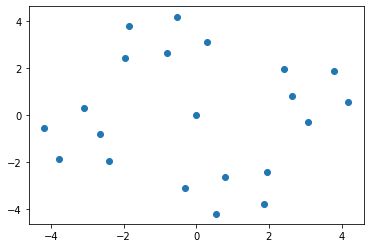

In [28]:
plt.scatter(*zip(*points))

Now we do the same thing except we use the poincare metric (called b2 in the code)

In [31]:
points2 = init_points(21, key)
b2 = lambda x, y: np.arccosh(1 + 2*(np.linalg.norm(x-y)**2)/((1-np.linalg.norm(y)**2)*(1-np.linalg.norm(x)**2)))
invTensorMagnitudeB2 = lambda x: (1-np.linalg.norm(x)**2)**2/4

@jit
def energy2(points):
    energy = 0
    for i in range(len(points)):
        for j in range(len(points)):
            if i == j:
                continue
            energy += 1/b2(points[i], points[j])
            if j == 4*i + 2 or j == 4*i + 1 or j == 4*i + 3 or j == 4*i + 4:
                energy += b2(points[i], points[j])**2
    return energy

dEnergy2 = jit(grad(energy2))

def update2(points, lr=1e-4):
    gradEnergy = dEnergy2(points)
    return [p - np.clip(g*invTensorMagnitudeB2(p),-1,1)*lr for p, g in zip(points, gradEnergy)]
        
iterations = 200001
every = 1000

for i in range(iterations):
    if i % every == 0:
        print("%6d of %6d. Energy: %f" % (i, iterations, energy2(points2)))
    points2 = jit(update2)(points2, lr=1e-4)


     0 of 200001. Energy: 153643.406250
  1000 of 200001. Energy: 1797.001465
  2000 of 200001. Energy: 887.618958
  3000 of 200001. Energy: 582.009888
  4000 of 200001. Energy: 436.470123
  5000 of 200001. Energy: 365.787781
  6000 of 200001. Energy: 319.314148
  7000 of 200001. Energy: 289.214050
  8000 of 200001. Energy: 270.071442
  9000 of 200001. Energy: 259.803223
 10000 of 200001. Energy: 253.630432
 11000 of 200001. Energy: 248.912628
 12000 of 200001. Energy: 245.111984
 13000 of 200001. Energy: 242.281708
 14000 of 200001. Energy: 240.121475
 15000 of 200001. Energy: 238.698410
 16000 of 200001. Energy: 237.676956
 17000 of 200001. Energy: 236.736511
 18000 of 200001. Energy: 235.822998
 19000 of 200001. Energy: 234.949554
 20000 of 200001. Energy: 234.078918
 21000 of 200001. Energy: 233.164185
 22000 of 200001. Energy: 232.229202
 23000 of 200001. Energy: 231.371658
 24000 of 200001. Energy: 230.647049
 25000 of 200001. Energy: 230.025375
 26000 of 200001. Energy: 229.4403

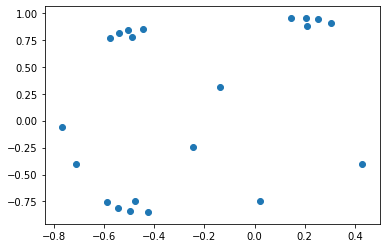

In [32]:
plt.scatter(*zip(*points2))